<a href="https://colab.research.google.com/github/StudentHagal/Thesis/blob/main/Dataset_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Preparation

## Load Requirements

In [1]:
# Libraries
import sys
import pandas as pd
import hashlib
import matplotlib
import numpy as np
import sklearn
import scipy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from imblearn.over_sampling import SMOTE
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

#Extension
!pip install ipython-autotime
%load_ext autotime
!git clone https://github.com/StudentHagal/Thesis.git

print('Load completed')


Cloning into 'Thesis'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 229 (delta 84), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (229/229), 11.56 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Load completed
time: 7.59 s (started: 2022-01-10 13:14:17 +00:00)


## Check Lib version

In [2]:
# Check the versions of libraries
# !!! WARNING !!!
# Important because model result may be different for other version
 
print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pd.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('joblib: {}'.format(joblib.__version__))

Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
sklearn: 1.0.1
joblib: 1.1.0
time: 9.76 ms (started: 2022-01-10 13:14:25 +00:00)


## Global Variables declaration

In [3]:
# Global Variable

#known hash value of file
compare = '10f68054068bc4ac4d7fee65e8fd7a184151e3ce3abce5d85350fc13c412d93b'    
#Stored file path                     
raw_file = "/content/Thesis/Resources/database.csv"
#environment path         
model_dir = '/content/Thesis/Resources/models/'                                  
process_dir = '/content/Thesis/Resources/processed/'
#Column names for dataset
col_names = ['No', 'Datetime', 'Control_Mode', 'L1', 'L2', 'L3', 'Frequency', 'kVA_Total',           
             'kVA_L1', 'kVA_L2', 'kVA_L3', 'KVAr', 'Oil_Pressure', 'Coolant_Temp', 
             'Charger_Alternator', 'PF_Avg', 'PF_L1', 'PF_L2', 
             'PF_L3', 'L1_N', 'L2_N', 'L3_N', 'Source_Ext_Voltage', 'ECU_Temp', 
             'RPM', 'Train_code']
sensors = ['L1', 'L2', 'L3', 'Frequency', 'kVA_Total',           
             'kVA_L1', 'kVA_L2', 'kVA_L3', 'KVAr', 'Oil_Pressure', 'Coolant_Temp', 
             'Charger_Alternator', 'PF_Avg', 'PF_L1', 'PF_L2', 
             'PF_L3', 'L1_N', 'L2_N', 'L3_N', 'Source_Ext_Voltage', 'ECU_Temp', 
             'RPM']
features = ['Oil_Pressure', 'Coolant_Temp', 'PF_Avg', 'ECU_Temp']
df = pd.read_csv(raw_file, names=col_names)

#columns with numeric dtype for calculating z-score
numeric_col = ['Control_Mode', 'L1', 'L2', 'L3', 'Frequency', 'kVA_Total',           
             'kVA_L1', 'kVA_L2', 'kVA_L3', 'KVAr', 'Oil_Pressure', 'Coolant_Temp', 
             'Charger_Alternator', 'PF_Avg', 'PF_L1', 'PF_L2', 
             'PF_L3', 'L1_N', 'L2_N', 'L3_N', 'Source_Ext_Voltage', 'ECU_Temp', 
             'RPM']



time: 141 ms (started: 2022-01-10 13:14:25 +00:00)


## Define Function

In [4]:
#Function to show cluster result
def show_clusters(dataset, labels):
  df = pd.DataFrame(dict(x=X_transform['P1'], y=X_transform['P2'], label=labels))
  colors = {-1:'black', 0:'blue', 1:'red', 2:'yellow' ,3:'green', 4:'orange'}
  fig, ax = plt.subplots(figsize=(8,8))
  grouped = df.groupby('label')
  for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.xlabel('P1')
  plt.ylabel('P2')
  plt.title('Estimated number of clusters: %d' %len(set(labels)))
  plt.show()


time: 11.1 ms (started: 2022-01-10 13:14:25 +00:00)


In [5]:
# Function that returns the SHA-2 hash of the file
def hash_file(filepath):

   # make a hash object with SHA-2
   h = hashlib.sha256()

   # open file for reading in binary mode
   with open(filepath,'rb') as file:
       # loop till the end of the file
       chunk = 0
       while chunk != b'':
           # read only 1024 bytes at a time
           chunk = file.read(1024)
           h.update(chunk)

   # return the hex representation of digest
   return h.hexdigest()


time: 6.95 ms (started: 2022-01-10 13:14:25 +00:00)


In [6]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

time: 6.32 ms (started: 2022-01-10 13:14:25 +00:00)


# 1) Processing Dataset

### Hash Validation

In [7]:
# Checking hash value of a file
compare = '10f68054068bc4ac4d7fee65e8fd7a184151e3ce3abce5d85350fc13c412d93b'
message = hash_file(raw_file)
print('SHA-256 value of your file is :')
print(message)

if (compare == message) :
  print('Hash check SUCCESS')
else :
  print('Hash check INVALID')

SHA-256 value of your file is :
10f68054068bc4ac4d7fee65e8fd7a184151e3ce3abce5d85350fc13c412d93b
Hash check SUCCESS
time: 29.3 ms (started: 2022-01-10 13:14:25 +00:00)


## Feature Selection

In [8]:
# Summarize raw dataset
pd.set_option('display.max_columns', None)
# size of (row, column) data
print('Total data size : ', df.shape)
# show sample entry of data
df.head(5)

Total data size :  (34357, 26)


,No,Datetime,Control_Mode,L1,L2,L3,Frequency,kVA_Total,kVA_L1,kVA_L2,kVA_L3,KVAr,Oil_Pressure,Coolant_Temp,Charger_Alternator,PF_Avg,PF_L1,PF_L2,PF_L3,L1_N,L2_N,L3_N,Source_Ext_Voltage,ECU_Temp,RPM,Train_code
0,1.1,01-08-20 02:03,2.0,28.0,27.0,26.0,50.0,18.51,6.35,6.09,5.89,0.00,636.0,81.0,26.9,0.83,0.83,0.82,0.84,220.8,221.1,220.8,25.98,32767.0,1499.0,MP3-01605
1,1.2,01-08-20 03:00,2.0,39.0,39.0,37.0,50.0,25.74,8.65,8.45,8.24,0.00,636.0,81.0,26.9,0.76,0.77,0.75,0.77,220.8,220.5,220.8,25.84,32767.0,1501.0,MP3-01605
2,1.3,01-08-20 04:00,2.0,104.0,100.0,100.0,50.0,68.59,22.89,22.32,22.02,46.74,632.0,82.0,26.9,0.77,0.77,0.76,0.77,220.2,220.7,220.5,25.93,32767.0,1499.0,MP3-01605
3,1.4,01-08-20 05:00,2.0,90.0,87.0,87.0,50.0,59.36,19.81,19.30,19.15,39.78,632.0,82.0,26.9,0.78,0.78,0.77,0.78,220.5,220.5,220.8,26.18,32767.0,1500.0,MP3-01605
4,1.5,01-08-20 06:00,2.0,98.0,96.0,96.0,50.0,64.60,21.66,21.14,21.14,43.31,628.0,82.0,27.0,0.78,0.77,0.78,0.78,220.3,220.4,220.6,26.14,32767.0,1500.0,MP3-01605


time: 42 ms (started: 2022-01-10 13:14:25 +00:00)


In [9]:
# statistical value of data
df.describe()


,No,Control_Mode,L1,L2,L3,Frequency,kVA_Total,kVA_L1,kVA_L2,kVA_L3,KVAr,Oil_Pressure,Coolant_Temp,Charger_Alternator,PF_Avg,PF_L1,PF_L2,PF_L3,L1_N,L2_N,L3_N,Source_Ext_Voltage,ECU_Temp,RPM
count,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,3.383200e+04,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000
mean,16.382906,1.531893,104.661208,103.481822,103.836072,41.849285,69.517004,23.098147,22.853998,22.919337,2.567771e+04,1533.996364,663.118379,23.126040,5.953150,5.577243,5.935014,6.347120,186.349900,186.401478,186.174010,23.340322,6278.678647,1345.971831
std,9.070813,0.810421,79.092619,78.685596,78.725843,18.329195,52.483808,17.573883,17.497579,17.482340,3.308827e+05,8092.570600,4389.881127,10.263944,40.234364,39.608321,41.013527,42.585116,80.731685,80.867993,80.890586,9.010295,12862.110888,2602.133855
min,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.200000,1.000000,39.000000,38.000000,38.000000,50.000000,26.037500,8.440000,8.280000,8.260000,9.680000e+00,592.000000,76.000000,27.100000,0.780000,0.780000,0.780000,0.780000,219.600000,219.700000,219.675000,26.330000,36.000000,1499.000000
50%,16.900000,2.000000,104.000000,103.000000,103.000000,50.000000,69.020000,22.985000,22.725000,22.940000,3.354000e+01,612.000000,81.000000,27.700000,0.870000,0.870000,0.860000,0.860000,221.100000,221.300000,221.100000,27.110000,41.000000,1499.000000
75%,24.360000,2.000000,159.000000,157.000000,157.000000,50.000000,105.420000,35.160000,34.700000,34.680000,5.388000e+01,624.000000,82.000000,27.900000,0.890000,0.890000,0.890000,0.880000,222.200000,222.400000,222.300000,27.300000,48.000000,1500.000000
max,31.990000,5.000000,555.000000,562.000000,557.000000,51.900000,376.510000,125.340000,127.240000,125.700000,4.294967e+06,65535.000000,65531.000000,29.900000,327.650000,327.650000,327.650000,327.650000,227.800000,227.900000,229.100000,30.720000,32767.000000,65531.000000


time: 122 ms (started: 2022-01-10 13:14:25 +00:00)


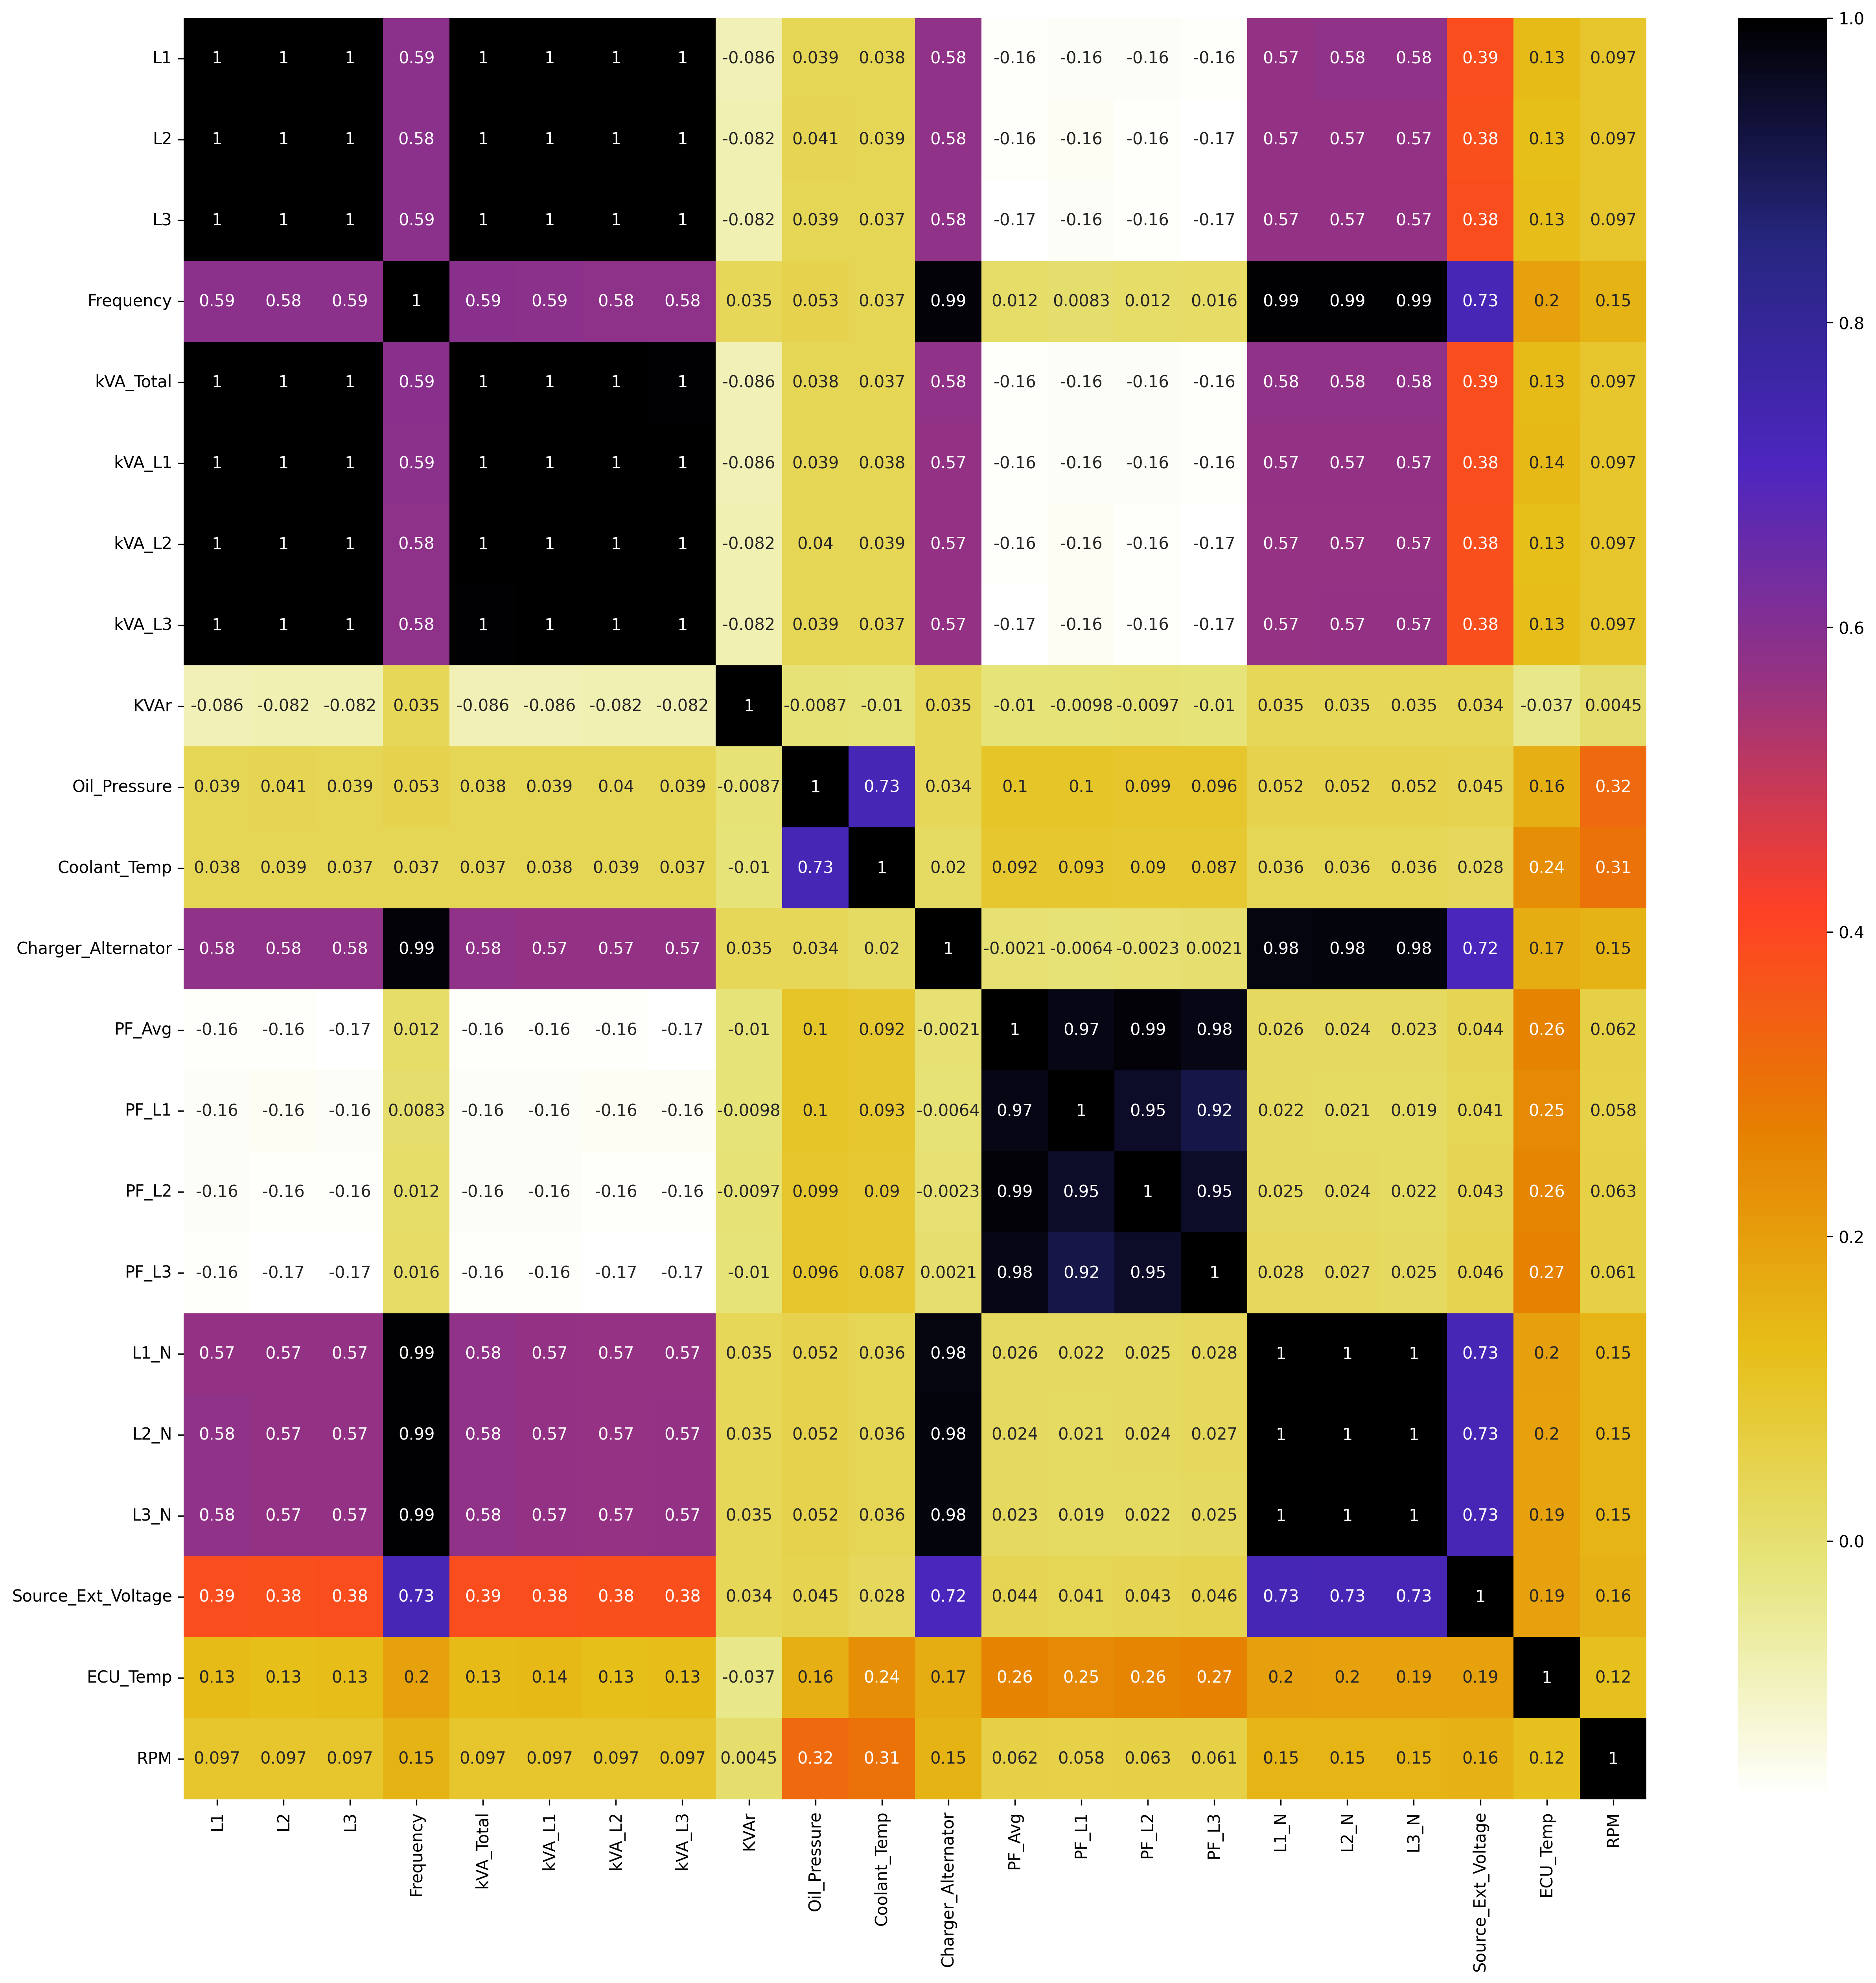

time: 5.9 s (started: 2022-01-10 13:14:25 +00:00)


In [10]:
#Using Pearson Correlation
plt.figure(figsize=(20,20), dpi=300)
cor = df[sensors].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

#export correlation table
cor.to_csv(process_dir+'pearson_corr.csv')

In [11]:
# class distribution
df.groupby('Train_code').size()

Train_code
MP3-01605    1434
MP3-01606     983
P-01601       423
P-01801      1922
P-01808      3068
P-01810      2570
P-01811      2258
P-01812      1231
P-01818      2280
P-01820      2186
P-01821      2006
P-01822      2901
P-01823       867
P-01825      1396
P-01903      2128
P-01908      3187
P-01914      2992
dtype: int64

time: 11.1 ms (started: 2022-01-10 13:14:31 +00:00)


In [12]:
#Data cleaning
# fill nan
df = df.dropna()
#drop duplicates
df = df.drop_duplicates()
df

,No,Datetime,Control_Mode,L1,L2,L3,Frequency,kVA_Total,kVA_L1,kVA_L2,kVA_L3,KVAr,Oil_Pressure,Coolant_Temp,Charger_Alternator,PF_Avg,PF_L1,PF_L2,PF_L3,L1_N,L2_N,L3_N,Source_Ext_Voltage,ECU_Temp,RPM,Train_code
0,1.10,01-08-20 02:03,2.0,28.0,27.0,26.0,50.0,18.51,6.35,6.09,5.89,0.00,636.0,81.0,26.9,0.83,0.83,0.82,0.84,220.8,221.1,220.8,25.98,32767.0,1499.0,MP3-01605
1,1.20,01-08-20 03:00,2.0,39.0,39.0,37.0,50.0,25.74,8.65,8.45,8.24,0.00,636.0,81.0,26.9,0.76,0.77,0.75,0.77,220.8,220.5,220.8,25.84,32767.0,1501.0,MP3-01605
2,1.30,01-08-20 04:00,2.0,104.0,100.0,100.0,50.0,68.59,22.89,22.32,22.02,46.74,632.0,82.0,26.9,0.77,0.77,0.76,0.77,220.2,220.7,220.5,25.93,32767.0,1499.0,MP3-01605
3,1.40,01-08-20 05:00,2.0,90.0,87.0,87.0,50.0,59.36,19.81,19.30,19.15,39.78,632.0,82.0,26.9,0.78,0.78,0.77,0.78,220.5,220.5,220.8,26.18,32767.0,1500.0,MP3-01605
4,1.50,01-08-20 06:00,2.0,98.0,96.0,96.0,50.0,64.60,21.66,21.14,21.14,43.31,628.0,82.0,27.0,0.78,0.77,0.78,0.78,220.3,220.4,220.6,26.14,32767.0,1500.0,MP3-01605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34352,31.39,31-12-20 13:00,2.0,194.0,184.0,199.0,50.0,129.67,43.40,41.10,44.10,67.90,600.0,83.0,27.7,0.88,0.88,0.87,0.88,223.3,222.6,221.1,27.64,32767.0,1500.0,P-01914
34353,31.40,31-12-20 14:00,2.0,173.0,165.0,180.0,50.0,115.63,38.60,36.90,39.80,60.90,604.0,82.0,27.7,0.88,0.88,0.87,0.88,223.3,222.8,221.0,27.54,32767.0,1500.0,P-01914
34354,31.41,31-12-20 15:00,2.0,169.0,163.0,176.0,50.0,112.96,37.80,36.40,38.80,60.20,604.0,81.0,27.9,0.87,0.87,0.87,0.88,223.4,222.6,221.3,27.74,32767.0,1499.0,P-01914
34355,31.42,31-12-20 16:00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,P-01914


time: 165 ms (started: 2022-01-10 13:14:31 +00:00)


In [13]:
# convert Datetime Dtype
df['Datetime'] = pd.to_datetime(df.Datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33832 entries, 0 to 34356
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  33832 non-null  float64       
 1   Datetime            33832 non-null  datetime64[ns]
 2   Control_Mode        33832 non-null  float64       
 3   L1                  33832 non-null  float64       
 4   L2                  33832 non-null  float64       
 5   L3                  33832 non-null  float64       
 6   Frequency           33832 non-null  float64       
 7   kVA_Total           33832 non-null  float64       
 8   kVA_L1              33832 non-null  float64       
 9   kVA_L2              33832 non-null  float64       
 10  kVA_L3              33832 non-null  float64       
 11  KVAr                33832 non-null  float64       
 12  Oil_Pressure        33832 non-null  float64       
 13  Coolant_Temp        33832 non-null  float64   

In [14]:
# Feature selection

#Columns which are highly correlated
unused_col = correlation(df, 0.75)
unused_col
#Non-sensor columns in dataset
unused_col.add('No')
unused_col.add('Control_Mode')
#Columns which IQR value (25% - 75%) doesn't have many variations from df.describe().
unused_col.add('RPM')
unused_col.add('Source_Ext_Voltage')
unused_col.add('Charger_Alternator')
unused_col.add('Frequency')

# delete columns with condition
df.drop(labels=unused_col, axis=1, inplace=True)
df

,Datetime,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp,Train_code
0,2020-01-08 02:03:00,28.0,0.00,636.0,81.0,0.83,32767.0,MP3-01605
1,2020-01-08 03:00:00,39.0,0.00,636.0,81.0,0.76,32767.0,MP3-01605
2,2020-01-08 04:00:00,104.0,46.74,632.0,82.0,0.77,32767.0,MP3-01605
3,2020-01-08 05:00:00,90.0,39.78,632.0,82.0,0.78,32767.0,MP3-01605
4,2020-01-08 06:00:00,98.0,43.31,628.0,82.0,0.78,32767.0,MP3-01605
...,...,...,...,...,...,...,...,...
34352,2020-12-31 13:00:00,194.0,67.90,600.0,83.0,0.88,32767.0,P-01914
34353,2020-12-31 14:00:00,173.0,60.90,604.0,82.0,0.88,32767.0,P-01914
34354,2020-12-31 15:00:00,169.0,60.20,604.0,81.0,0.87,32767.0,P-01914
34355,2020-12-31 16:00:00,0.0,0.00,0.0,0.0,0.00,0.0,P-01914


time: 89.6 ms (started: 2022-01-10 13:14:35 +00:00)


In [15]:
# statistical value of data
df.describe()

,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp
count,33832.000000,3.383200e+04,33832.000000,33832.000000,33832.000000,33832.000000
mean,104.661208,2.567771e+04,1533.996364,663.118379,5.953150,6278.678647
std,79.092619,3.308827e+05,8092.570600,4389.881127,40.234364,12862.110888
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,39.000000,9.680000e+00,592.000000,76.000000,0.780000,36.000000
50%,104.000000,3.354000e+01,612.000000,81.000000,0.870000,41.000000
75%,159.000000,5.388000e+01,624.000000,82.000000,0.890000,48.000000
max,555.000000,4.294967e+06,65535.000000,65531.000000,327.650000,32767.000000


time: 40.4 ms (started: 2022-01-10 13:14:35 +00:00)


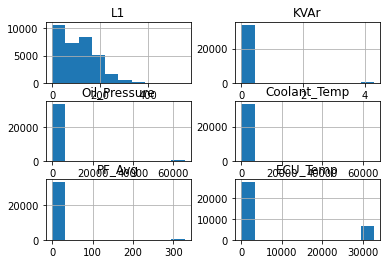

time: 928 ms (started: 2022-01-10 13:14:35 +00:00)


In [16]:
# visualisasi dalam grafik
df.hist()
pyplot.show()

## Data Processing

In [17]:
#Threshold value variable 25% min, 75% max
oil_q25, oil_q75 = df.Oil_Pressure.quantile([0.25 , 0.75])
coolant_q25, coolant_q75 = df.Coolant_Temp.quantile([0.25 , 0.75])
pf_q25, pf_q75 = df.PF_Avg.quantile([0.25 , 0.75])
ecu_q25, ecu_q75 = df.ECU_Temp.quantile([0.25 , 0.75])
# calculate the outlier cutoff per-feature
#feature 1
oil_cut_off = (oil_q75 - oil_q25)*1.5
oil_lower, oil_upper = oil_q25 - oil_cut_off, oil_q75 + oil_cut_off
#feature 2
coolant_cut_off = (coolant_q75 - coolant_q25)*1.5
coolant_lower, coolant_upper = coolant_q25 - coolant_cut_off, coolant_q75 + coolant_cut_off
#feature 3
pf_cut_off = (pf_q75 - pf_q25)*1.5
pf_lower, pf_upper = pf_q25 - pf_cut_off, pf_q75 + pf_cut_off
#feature 4
ecu_cut_off = (ecu_q75 - ecu_q25)*1.5
ecu_lower, ecu_upper = ecu_q25 - ecu_cut_off, ecu_q75 + ecu_cut_off

time: 24.1 ms (started: 2022-01-10 13:14:36 +00:00)


In [18]:
q25 = df.quantile(q=0.25)
q75 = df.quantile(q=0.75)
iqr = (q75 - q25)
cut_off = iqr*1.5
lower, upper  = (q25 - cut_off), (q75 + cut_off)

#Print quantile value for label threshold
print('1st Quantile values (25%) :')
print(q25)
print('3rd Quantile values (75%) :')
print(q75)
print('IQR values (75%-25%) :')
print(iqr)
print('Lower Threshold values :')
print(lower)
print('Upper Threshold values :')
print(upper)

1st Quantile values (25%) :
L1               39.00
KVAr              9.68
Oil_Pressure    592.00
Coolant_Temp     76.00
PF_Avg            0.78
ECU_Temp         36.00
Name: 0.25, dtype: float64
3rd Quantile values (75%) :
L1              159.00
KVAr             53.88
Oil_Pressure    624.00
Coolant_Temp     82.00
PF_Avg            0.89
ECU_Temp         48.00
Name: 0.75, dtype: float64
IQR values (75%-25%) :
L1              120.00
KVAr             44.20
Oil_Pressure     32.00
Coolant_Temp      6.00
PF_Avg            0.11
ECU_Temp         12.00
dtype: float64
Lower Threshold values :
L1             -141.000
KVAr            -56.620
Oil_Pressure    544.000
Coolant_Temp     67.000
PF_Avg            0.615
ECU_Temp         18.000
dtype: float64
Upper Threshold values :
L1              339.000
KVAr            120.180
Oil_Pressure    672.000
Coolant_Temp     91.000
PF_Avg            1.055
ECU_Temp         66.000
dtype: float64
time: 26.7 ms (started: 2022-01-10 13:14:36 +00:00)


In [19]:
#amount of Outlier data for each feature
Outlier_data = df[(df[features] < lower) | (df[features] > upper)].count()
print('Outlier data Count :')
print(Outlier_data)
#amount of Maintenance data for each feature
Maintenance_data = df[((df[features] > lower) & (df[features] < q25)) | ((df[features] > q75) & (df[features] < upper))]
print('Maintenance data Count :')
print(Maintenance_data.count())
#amount of Normal data for each feature
Normal_data = df[(df[features] > q25) & (df[features] < q75)]
print('Normal data Count :')
print(Normal_data.count())

Outlier data Count :
Datetime            0
L1                  0
KVAr                0
Oil_Pressure     6699
Coolant_Temp     7703
PF_Avg           6716
ECU_Temp        11596
Train_code          0
dtype: int64
Maintenance data Count :
Datetime           0
L1                 0
KVAr               0
Oil_Pressure    8672
Coolant_Temp    6759
PF_Avg          7655
ECU_Temp        4290
Train_code         0
dtype: int64
Normal data Count :
Datetime            0
L1                  0
KVAr                0
Oil_Pressure    16148
Coolant_Temp    11890
PF_Avg          16111
ECU_Temp        15942
Train_code          0
dtype: int64
time: 140 ms (started: 2022-01-10 13:14:36 +00:00)


In [20]:
# Scaling and Normalize data
features_norm = ['Oil_Pressure_Norm',	'Coolant_Temp_Norm',	'PF_Avg_Norm',	'ECU_Temp_Norm']
X_scaled = StandardScaler().fit_transform(df[features])         #Bring all the attributes to a comparable level (Z-score normalization)
X_normalized = normalize(X_scaled)                              #Centering data to Origin
X_normalized = pd.DataFrame(X_normalized, columns=features_norm)     #Converting the numpy array into a pandas DataFrame
X_normalized

,Oil_Pressure_Norm,Coolant_Temp_Norm,PF_Avg_Norm,ECU_Temp_Norm
0,-0.053592,-0.064042,-0.061496,0.994608
1,-0.053589,-0.064039,-0.062333,0.994556
2,-0.053828,-0.063929,-0.062213,0.994558
3,-0.053828,-0.063930,-0.062094,0.994565
4,-0.054066,-0.063929,-0.062093,0.994552
...,...,...,...,...
33827,-0.055736,-0.063818,-0.060892,0.994542
33828,-0.055498,-0.063929,-0.060893,0.994548
33829,-0.055497,-0.064038,-0.061012,0.994533
33830,-0.335650,-0.267477,-0.261998,-0.864380


time: 26.1 ms (started: 2022-01-10 13:14:36 +00:00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb16a6e0510>,
      dtype=object)

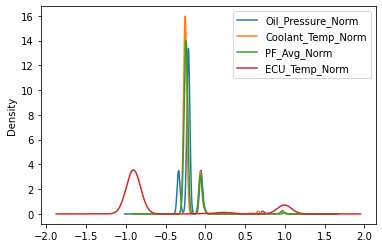

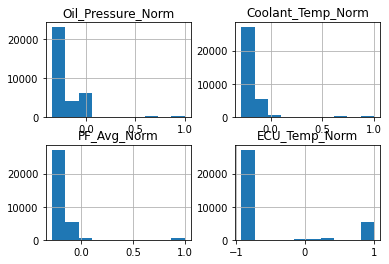

time: 4.9 s (started: 2022-01-10 13:14:36 +00:00)


In [21]:
X_normalized.plot.kde()  #Density estimation
X_normalized.hist()      # Visualize data using histograms

### Data Labelling

In [22]:
#Stat_Outlier = (value < q25 - (q75-q25) * 1.5) or (value > q75 + (q75-q25) * 1.5)
Outlier_Oil = (df['Oil_Pressure'] < oil_lower) | (df['Oil_Pressure'] > oil_upper)
Outlier_Coolant =(df['Coolant_Temp'] < coolant_lower) | (df['Coolant_Temp'] > coolant_upper) 
Outlier_ECU = (df['ECU_Temp'] < ecu_lower) | (df['ECU_Temp'] > ecu_upper) 
Outlier_PFA = (df['PF_Avg'] < pf_lower) | (df['PF_Avg'] > pf_upper)

#Stat_Maintenance = (q25 - (q75-q25) * 1.5 <= value <= q25) or (q75 <= value <= q75 + (q75-q25) * 1.5)
Maintenance_Oil = (df['Oil_Pressure'].between(oil_lower, oil_q25)) | (df['Oil_Pressure'].between(oil_q75, oil_upper))
Maintenance_Coolant = (df['Coolant_Temp'].between(coolant_lower, coolant_q25)) | (df['Coolant_Temp'].between(coolant_q75, coolant_upper)) 
Maintenance_ECU = (df['ECU_Temp'].between(ecu_lower, ecu_q25)) | (df['ECU_Temp'].between(ecu_q75, ecu_upper))
Maintenance_PFA = (df['PF_Avg'].between(pf_lower, pf_q25) | (df['PF_Avg'].between(pf_q75, pf_upper)))

#Stat_Normal = q25 < value < q75 
Normal_Oil = df['Oil_Pressure'].between(oil_q25, oil_q75, inclusive=False) 
Normal_Coolant = df['Coolant_Temp'].between(coolant_q25, coolant_q75, inclusive=False)
Normal_ECU = df['ECU_Temp'].between(ecu_q25, ecu_q75, inclusive=False) 
Normal_PFA = df['PF_Avg'].between(pf_q25, pf_q75, inclusive=False)

#Label Condition
Outlier =  Outlier_Oil & Outlier_Coolant & Outlier_ECU & Outlier_PFA
Maintenance = Maintenance_Oil | Maintenance_Coolant |  Maintenance_ECU | Maintenance_PFA


time: 35.2 ms (started: 2022-01-10 13:14:41 +00:00)


In [23]:
#Check conditions for each row in dataframe, preserve original DataFrame from raw data
#If ALL Features fulfill Outlier condition then Label 'Outlier'
#If ANY Features fulfill Maintenance condition then Label 'Maintenance'
#else Label 'Normal'
df_dataset1 = df[features].copy()
df_dataset1['Label'] = 'Normal'
df_dataset1.loc[Outlier, 'Label'] = 'Outlier'
df_dataset1.loc[Maintenance, 'Label'] = 'Maintenance'

#add label to original data
df_dataset1 = pd.concat([df, df_dataset1.Label], axis=1, join='outer')

#Dataset 1 (With 3 Label: Outlier, Maintenance, Normal)
# class distribution
print('Dataset 1 label:')
print(df_dataset1.groupby('Label').size())

# Dataset 2 (With 2 Label: Maintenance, Normal) can be obtained from previous dataset
# No need to create separate file.
#Dataset 2
df_dataset2 = df_dataset1[df_dataset1.Label != 'Outlier']
print('Dataset 2 no Outlier :')
print(df_dataset2.groupby('Label').size())


Dataset 1 label:
Label
Maintenance    24159
Normal          4414
Outlier         5259
dtype: int64
Dataset 2 no Outlier :
Label
Maintenance    24159
Normal          4414
dtype: int64
time: 35.9 ms (started: 2022-01-10 13:14:41 +00:00)


In [24]:
df_dataset1

,Datetime,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp,Train_code,Label
0,2020-01-08 02:03:00,28.0,0.00,636.0,81.0,0.83,32767.0,MP3-01605,Maintenance
1,2020-01-08 03:00:00,39.0,0.00,636.0,81.0,0.76,32767.0,MP3-01605,Maintenance
2,2020-01-08 04:00:00,104.0,46.74,632.0,82.0,0.77,32767.0,MP3-01605,Maintenance
3,2020-01-08 05:00:00,90.0,39.78,632.0,82.0,0.78,32767.0,MP3-01605,Maintenance
4,2020-01-08 06:00:00,98.0,43.31,628.0,82.0,0.78,32767.0,MP3-01605,Maintenance
...,...,...,...,...,...,...,...,...,...
34352,2020-12-31 13:00:00,194.0,67.90,600.0,83.0,0.88,32767.0,P-01914,Maintenance
34353,2020-12-31 14:00:00,173.0,60.90,604.0,82.0,0.88,32767.0,P-01914,Maintenance
34354,2020-12-31 15:00:00,169.0,60.20,604.0,81.0,0.87,32767.0,P-01914,Normal
34355,2020-12-31 16:00:00,0.0,0.00,0.0,0.0,0.00,0.0,P-01914,Outlier


time: 27.8 ms (started: 2022-01-10 13:14:41 +00:00)


### Clustering Data

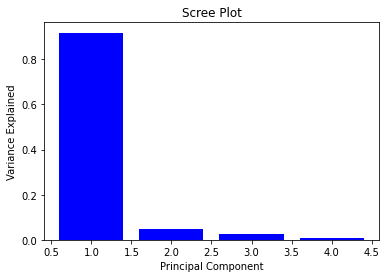

PCA Explained Variance ratio in order : 
[0.91817387 0.04673302 0.02602986 0.00906325]
time: 238 ms (started: 2022-01-10 13:14:41 +00:00)


In [25]:
# reduce dimension for easier visualization using Principal Component Analysis (PCA)

# set n_components value based on the numbers of features, then select two with highest variation
pca = PCA(n_components = 4)
pca.fit(X_normalized)

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.bar(x=PC_values, height=pca.explained_variance_ratio_, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print('PCA Explained Variance ratio in order : ')
print(pca.explained_variance_ratio_)

         P1        P2        P3        P4
0  1.566550 -0.118598 -0.022352 -0.011695
1  1.566389 -0.119012 -0.023064 -0.011704
2  1.566392 -0.119030 -0.022915 -0.011457
3  1.566415 -0.118971 -0.022814 -0.011456
4  1.566374 -0.119109 -0.022725 -0.011288
5  1.566420 -0.118991 -0.022522 -0.011285
6  1.566384 -0.119149 -0.022142 -0.010947
7  1.566320 -0.119347 -0.022155 -0.010781
8  1.566384 -0.119149 -0.022142 -0.010947
9  1.566410 -0.119108 -0.021892 -0.010699


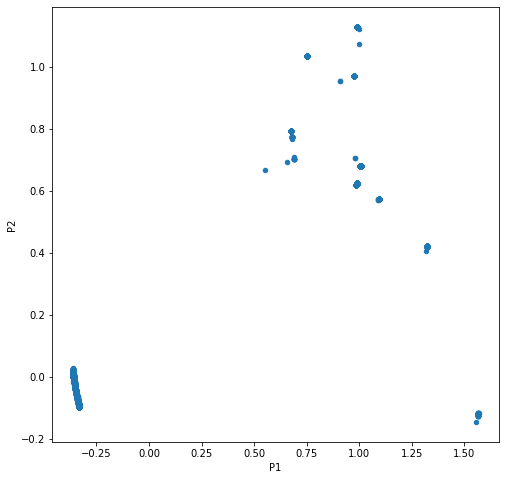

          x         y
0  1.566550 -0.118598
1  1.566389 -0.119012
2  1.566392 -0.119030
3  1.566415 -0.118971
4  1.566374 -0.119109
5  1.566420 -0.118991
6  1.566384 -0.119149
7  1.566320 -0.119347
8  1.566384 -0.119149
9  1.566410 -0.119108
time: 308 ms (started: 2022-01-10 13:14:41 +00:00)


In [26]:
# Scatter plot data
PCA_comp = ['P1', 'P2', 'P3', 'P4'] #set Px value based on the numbers of features
X_transform = pca.fit_transform(X_normalized)
X_transform = pd.DataFrame(X_transform, columns=PCA_comp)
print(X_transform.head(10))

# Select two PCA components with highest variation (Dimensionality reduction)
df_cluster = pd.DataFrame(dict(x=X_transform['P1'], y=X_transform['P2']))
fig, ax = plt.subplots(figsize=(8,8))
df_cluster.plot(ax=ax, kind='scatter', x='x', y='y')
plt.xlabel('P1')
plt.ylabel('P2')
plt.show()
print(df_cluster.head(10))

In [27]:
#Reset index to match new data
df_dataset1 = df_dataset1.set_index('Train_code')   #set new index to change the numbering order
df_dataset1 = df_dataset1.reset_index()             #reset index to restart numbering from 0 to n-1

#Merge Transformed features value into dataset
df_dataset1 = pd.concat([df_dataset1, X_transform], axis=1)
df_dataset1

,Train_code,Datetime,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,ECU_Temp,Label,P1,P2,P3,P4
0,MP3-01605,2020-01-08 02:03:00,28.0,0.00,636.0,81.0,0.83,32767.0,Maintenance,1.566550,-0.118598,-0.022352,-0.011695
1,MP3-01605,2020-01-08 03:00:00,39.0,0.00,636.0,81.0,0.76,32767.0,Maintenance,1.566389,-0.119012,-0.023064,-0.011704
2,MP3-01605,2020-01-08 04:00:00,104.0,46.74,632.0,82.0,0.77,32767.0,Maintenance,1.566392,-0.119030,-0.022915,-0.011457
3,MP3-01605,2020-01-08 05:00:00,90.0,39.78,632.0,82.0,0.78,32767.0,Maintenance,1.566415,-0.118971,-0.022814,-0.011456
4,MP3-01605,2020-01-08 06:00:00,98.0,43.31,628.0,82.0,0.78,32767.0,Maintenance,1.566374,-0.119109,-0.022725,-0.011288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33827,P-01914,2020-12-31 13:00:00,194.0,67.90,600.0,83.0,0.88,32767.0,Maintenance,1.566336,-0.119425,-0.021131,-0.010023
33828,P-01914,2020-12-31 14:00:00,173.0,60.90,604.0,82.0,0.88,32767.0,Maintenance,1.566356,-0.119348,-0.021177,-0.010269
33829,P-01914,2020-12-31 15:00:00,169.0,60.20,604.0,81.0,0.87,32767.0,Normal,1.566312,-0.119468,-0.021237,-0.010348
33830,P-01914,2020-12-31 16:00:00,0.0,0.00,0.0,0.0,0.00,0.0,Outlier,-0.333291,-0.095735,0.024376,0.058136


time: 42.5 ms (started: 2022-01-10 13:14:41 +00:00)


Estimated number of dbscan clusters: 3
Estimated number of noise points: 0


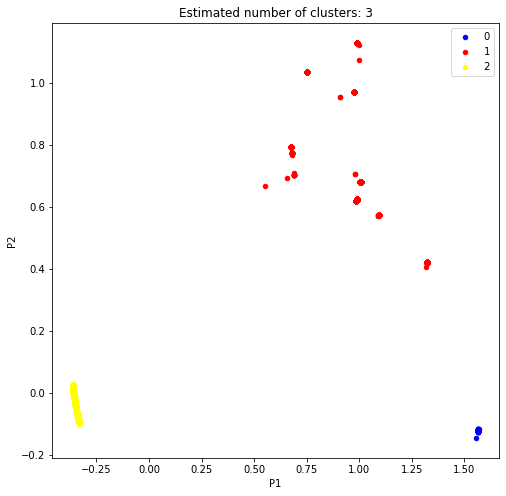

time: 16 s (started: 2022-01-10 13:14:42 +00:00)


In [28]:
# Fit Clustering algorithm

# Build DBSCAN Model
model_dbscan = DBSCAN(eps=0.5, min_samples=100)
model_dbscan.fit(df_cluster)
labels_dbscan = model_dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)
print('Estimated number of dbscan clusters: %d' %n_clusters_)
print('Estimated number of noise points: %d' %n_noise_)

# cluster result from DBSCAN
show_clusters(df_cluster, labels_dbscan)

Estimated number of kmeans clusters:  3


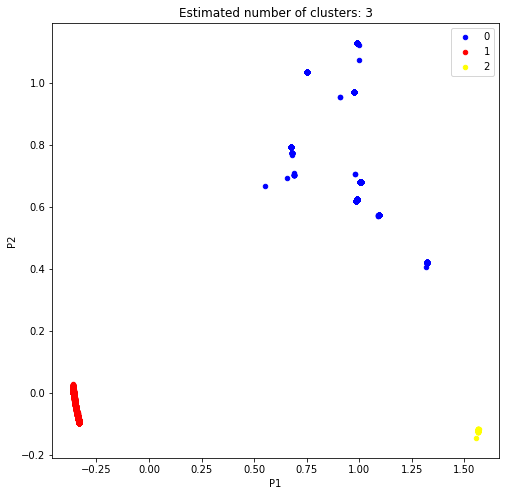

time: 901 ms (started: 2022-01-10 13:14:58 +00:00)


In [29]:
# Build K means model
model_Kmeans = KMeans(n_clusters=3, random_state=0)
model_Kmeans.fit(df_cluster)
labels_Kmeans = model_Kmeans.labels_
print('Estimated number of kmeans clusters: ', len(set(labels_Kmeans)))
# cluster result from K-Means
show_clusters(df_cluster, labels_Kmeans)

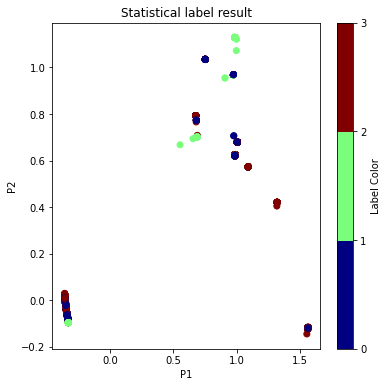

time: 1.06 s (started: 2022-01-10 13:14:58 +00:00)


In [30]:
# Compare with Statistical label result from dataset 1

# Convert string label (From statistical labeling) to integer
df_dataset1.insert(7, 'Label_id', value=np.nan)
df_dataset1.loc[df_dataset1['Label'] == 'Normal', ['Label_id']] = 0       #Normal = 0
df_dataset1.loc[df_dataset1['Label'] == 'Outlier', ['Label_id']] = 1      #Outlier = 1
df_dataset1.loc[df_dataset1['Label'] == 'Maintenance', ['Label_id']] = 2  #Maintenance = 2

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = X_transform['P1']
y = X_transform['P2']
N = 3 # Number of labels
tag = df_dataset1['Label_id'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap, norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Label Color')
plt.xlabel('P1')
plt.ylabel('P2')
ax.set_title('Statistical label result')
plt.show()

In [31]:
# add predicted cluster into dataset

#DBSCAN
df_dataset1.insert(8, 'clusters_dbscan', value=labels_dbscan)
print(df_dataset1.groupby('clusters_dbscan').size())

#Kmeans
df_dataset1.insert(8, 'clusters_kmeans', value=labels_Kmeans)
print(df_dataset1.groupby('clusters_kmeans').size())

clusters_dbscan
0     5400
1     1256
2    27176
dtype: int64
clusters_kmeans
0     1256
1    27176
2     5400
dtype: int64
time: 12.2 ms (started: 2022-01-10 13:15:00 +00:00)


In [32]:
df_dataset1

,Train_code,Datetime,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,Label_id,clusters_kmeans,clusters_dbscan,ECU_Temp,Label,P1,P2,P3,P4
0,MP3-01605,2020-01-08 02:03:00,28.0,0.00,636.0,81.0,0.83,2.0,2,0,32767.0,Maintenance,1.566550,-0.118598,-0.022352,-0.011695
1,MP3-01605,2020-01-08 03:00:00,39.0,0.00,636.0,81.0,0.76,2.0,2,0,32767.0,Maintenance,1.566389,-0.119012,-0.023064,-0.011704
2,MP3-01605,2020-01-08 04:00:00,104.0,46.74,632.0,82.0,0.77,2.0,2,0,32767.0,Maintenance,1.566392,-0.119030,-0.022915,-0.011457
3,MP3-01605,2020-01-08 05:00:00,90.0,39.78,632.0,82.0,0.78,2.0,2,0,32767.0,Maintenance,1.566415,-0.118971,-0.022814,-0.011456
4,MP3-01605,2020-01-08 06:00:00,98.0,43.31,628.0,82.0,0.78,2.0,2,0,32767.0,Maintenance,1.566374,-0.119109,-0.022725,-0.011288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33827,P-01914,2020-12-31 13:00:00,194.0,67.90,600.0,83.0,0.88,2.0,2,0,32767.0,Maintenance,1.566336,-0.119425,-0.021131,-0.010023
33828,P-01914,2020-12-31 14:00:00,173.0,60.90,604.0,82.0,0.88,2.0,2,0,32767.0,Maintenance,1.566356,-0.119348,-0.021177,-0.010269
33829,P-01914,2020-12-31 15:00:00,169.0,60.20,604.0,81.0,0.87,0.0,2,0,32767.0,Normal,1.566312,-0.119468,-0.021237,-0.010348
33830,P-01914,2020-12-31 16:00:00,0.0,0.00,0.0,0.0,0.00,1.0,1,2,0.0,Outlier,-0.333291,-0.095735,0.024376,0.058136


time: 38.8 ms (started: 2022-01-10 13:15:00 +00:00)


In [33]:
df_dataset1.describe()

,L1,KVAr,Oil_Pressure,Coolant_Temp,PF_Avg,Label_id,clusters_kmeans,clusters_dbscan,ECU_Temp,P1,P2,P3,P4
count,33832.000000,3.383200e+04,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,33832.000000,3.383200e+04,3.383200e+04,3.383200e+04,3.383200e+04
mean,104.661208,2.567771e+04,1533.996364,663.118379,5.953150,1.583619,1.122488,1.643651,6278.678647,1.523485e-15,-7.267380e-17,5.927204e-17,-9.537533e-17
std,79.092619,3.308827e+05,8092.570600,4389.881127,40.234364,0.709901,0.426309,0.740679,12862.110888,7.265950e-01,1.639237e-01,1.223393e-01,7.218916e-02
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.629585e-01,-1.449154e-01,-5.336419e-01,-7.053018e-01
25%,39.000000,9.680000e+00,592.000000,76.000000,0.780000,1.000000,1.000000,2.000000,36.000000,-3.613759e-01,-9.573502e-02,-9.168590e-03,-1.544291e-02
50%,104.000000,3.354000e+01,612.000000,81.000000,0.870000,2.000000,1.000000,2.000000,41.000000,-3.609193e-01,8.696314e-03,-6.033813e-03,-1.242664e-02
75%,159.000000,5.388000e+01,624.000000,82.000000,0.890000,2.000000,1.000000,2.000000,48.000000,-3.332909e-01,1.082132e-02,-4.248911e-03,-9.526722e-03
max,555.000000,4.294967e+06,65535.000000,65531.000000,327.650000,2.000000,2.000000,2.000000,32767.000000,1.567610e+00,1.128509e+00,8.868034e-01,7.359918e-01


time: 68.1 ms (started: 2022-01-10 13:15:00 +00:00)


In [34]:
#Export dataset into external file

df_dataset1.to_csv(process_dir+'final_dataset.csv')

time: 611 ms (started: 2022-01-10 13:15:00 +00:00)


### Synthetic Data
Using SMOTE, resample all data for each label.


In [35]:
# resampling & balancing dataset from statistical label with SMOTE

resampled_col = ['Oil_Pressure', 'Coolant_Temp', 'PF_Avg', 'ECU_Temp',
                 'P1',	'P2',	'P3',	'P4']

#Synthetic data generator
resampling = {'Outlier': 30000, 'Maintenance': 30000, 'Normal': 30000}
resampler_smote = SMOTE(random_state=1, sampling_strategy = resampling)
X1 = df_dataset1[resampled_col]
y1 = df_dataset1['Label']

print('Original dataset shape %s' % Counter(y1))
X1_test, Y1_test = resampler_smote.fit_resample(X1, y1)
df_X1_test = pd.DataFrame(X1_test, columns=resampled_col)
df_Y1_test = pd.DataFrame(Y1_test, columns=['Label'])
print('Resampled dataset shape %s' % Counter(Y1_test))
df_SMOTE_statistical = pd.concat([df_X1_test, df_Y1_test], axis=1)
print(df_SMOTE_statistical)

#export resampled df to csv
df_SMOTE_statistical.to_csv(process_dir+'SMOTE_statistical.csv')

Original dataset shape Counter({'Maintenance': 24159, 'Outlier': 5259, 'Normal': 4414})


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class Outlier will be larger than the number of samples in the majority class (class #Maintenance -> 24159)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class Maintenance will be larger than the number of samples in the majority class (class #Maintenance -> 24159)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class Normal will be larger than the number of samples in the majority class (class #Maintenance -> 24159)
  f"After over-sampling, the number of samples ({n_samples})"


Resampled dataset shape Counter({'Maintenance': 30000, 'Normal': 30000, 'Outlier': 30000})
       Oil_Pressure  Coolant_Temp  PF_Avg  ECU_Temp        P1        P2  \
0             636.0          81.0    0.83   32767.0  1.566550 -0.118598   
1             636.0          81.0    0.76   32767.0  1.566389 -0.119012   
2             632.0          82.0    0.77   32767.0  1.566392 -0.119030   
3             632.0          82.0    0.78   32767.0  1.566415 -0.118971   
4             628.0          82.0    0.78   32767.0  1.566374 -0.119109   
...             ...           ...     ...       ...       ...       ...   
89995           0.0           0.0    0.00       0.0 -0.333291 -0.095735   
89996           0.0           0.0    0.00       0.0 -0.333291 -0.095735   
89997           0.0           0.0    0.00       0.0 -0.333291 -0.095735   
89998           0.0           0.0    0.00       0.0 -0.333291 -0.095735   
89999           0.0           0.0    0.00       0.0 -0.333291 -0.095735   

        

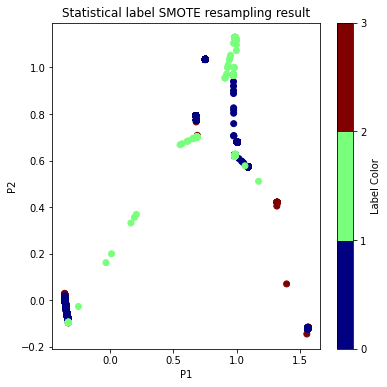

time: 2.23 s (started: 2022-01-10 13:15:03 +00:00)


In [36]:
# Show label result from statistical label after using SMOTE

# Convert string label (From statistical labeling) to integer
df_SMOTE_statistical.insert(7, 'Label_id', value=np.nan)
df_SMOTE_statistical.loc[df_SMOTE_statistical['Label'] == 'Normal', ['Label_id']] = 0       #Normal = 0
df_SMOTE_statistical.loc[df_SMOTE_statistical['Label'] == 'Outlier', ['Label_id']] = 1      #Outlier = 1
df_SMOTE_statistical.loc[df_SMOTE_statistical['Label'] == 'Maintenance', ['Label_id']] = 2  #Maintenance = 2

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df_SMOTE_statistical['P1']
y = df_SMOTE_statistical['P2']
N = 3 # Number of labels
tag = df_SMOTE_statistical['Label_id'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap, norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Label Color')
plt.xlabel('P1')
plt.ylabel('P2')
ax.set_title('Statistical label SMOTE resampling result')
plt.show()

In [37]:
# resampling & balancing dataset from clustering label with SMOTE
resampled_col = ['Oil_Pressure', 'Coolant_Temp', 'PF_Avg', 'ECU_Temp',
                 'P1',	'P2',	'P3',	'P4']

#Synthetic data generator
resampling = {0: 30000, 1: 30000, 2: 30000}
resampler_smote = SMOTE(random_state=1, sampling_strategy = resampling)
X2 = df_dataset1[resampled_col]
y2 = df_dataset1['clusters_dbscan']

print('Original dataset shape %s' % Counter(y2))
X2_test, Y2_test = resampler_smote.fit_resample(X2, y2)
df_X2_test = pd.DataFrame(X2_test, columns=resampled_col)
df_Y2_test = pd.DataFrame(Y2_test, columns=['clusters_dbscan'])
print('Resampled dataset shape %s' % Counter(Y2_test))
df_SMOTE_cluster = pd.concat([df_X2_test, df_Y2_test], axis=1)
print(df_SMOTE_cluster)

#export resampled df to csv
df_SMOTE_cluster.to_csv(process_dir+'SMOTE_cluster.csv')

Original dataset shape Counter({2: 27176, 0: 5400, 1: 1256})


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class 0 will be larger than the number of samples in the majority class (class #2 -> 27176)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class 1 will be larger than the number of samples in the majority class (class #2 -> 27176)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (30000) in class 2 will be larger than the number of samples in the majority class (class #2 -> 27176)
  f"After over-sampling, the number of samples ({n_samples})"


Resampled dataset shape Counter({0: 30000, 1: 30000, 2: 30000})
       Oil_Pressure  Coolant_Temp    PF_Avg  ECU_Temp        P1        P2  \
0             636.0          81.0  0.830000   32767.0  1.566550 -0.118598   
1             636.0          81.0  0.760000   32767.0  1.566389 -0.119012   
2             632.0          82.0  0.770000   32767.0  1.566392 -0.119030   
3             632.0          82.0  0.780000   32767.0  1.566415 -0.118971   
4             628.0          82.0  0.780000   32767.0  1.566374 -0.119109   
...             ...           ...       ...       ...       ...       ...   
89995         636.0          76.0  0.896625      41.0 -0.361634  0.012400   
89996         624.0          77.0  0.812171      45.0 -0.360997  0.008993   
89997         596.0          83.0  0.860000      48.0 -0.360898  0.007602   
89998           0.0           0.0  0.000000       0.0 -0.333291 -0.095735   
89999         624.0          79.0  0.888833      33.0 -0.361597  0.011817   

           

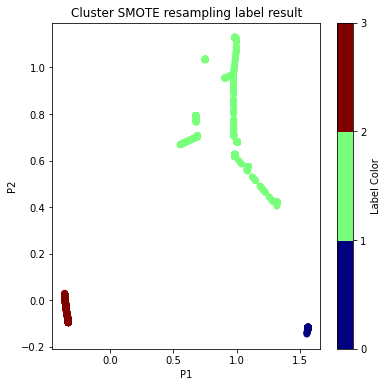

time: 2.2 s (started: 2022-01-10 13:15:07 +00:00)


In [38]:
# Show cluster result from DBSCAN after using SMOTE

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df_SMOTE_cluster['P1']
y = df_SMOTE_cluster['P2']
N = 3 # Number of labels
tag = df_SMOTE_cluster['clusters_dbscan'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap, norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Label Color')
plt.xlabel('P1')
plt.ylabel('P2')
ax.set_title('Cluster SMOTE resampling label result')
plt.show()